In [2]:
!pip install matplotlib

/Users/alexcismaru/.zshenv:1: bad assignment


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import json

country = 'new_york'
main_color = 'red'
models = ['DG', 'G', 'MFG', 'NG']
rounds = ['0']

# Standard Plots

In [8]:

dfs = []
# for r in rounds:
#     for model in models:
#         filename = 'tile2cpc_' + model + '_' + country + '_' + r + '.csv'
#         df = pd.read_csv('../results/'+filename)
#         df.set_index('tile', inplace=True)
#         df.fillna(0, inplace=True)
#         df.rename(columns={'cpc': r + '_' + model}, inplace=True)
#         dfs.append(df)
    
filename = 'tile2cpc_DG_new_york.csv'
df = pd.read_csv('deepgravity/results/'+filename)
df.set_index('tile', inplace=True)
df.fillna(0, inplace=True)
df.rename(columns={'cpc': '0' + '_' + 'DG'}, inplace=True)
dfs.append(df)
df = dfs[0]
    
for d in dfs[1:]:
     df = df.join(d)

# archive = zipfile.ZipFile('deepgravity/data/'+ country + '/processed/tileid2oa2handmade_features.json.zip', 'r')
# with archive.open('deepgravity/data/'+ country + '/processed/tileid2oa2handmade_features.json') as f:
#     tileid2oa2features2vals = json.load(f)
    
# Define the path to the unzipped JSON file
json_file_path = 'deepgravity/data/' + country + '/processed/tileid2oa2handmade_features.json'

# Open and load the JSON file
with open(json_file_path, 'r') as f:
    tileid2oa2features2vals = json.load(f)


df.reset_index(inplace=True)
df = df[df['tile'] != 0]
areas = list(df['tile'].unique())
tile_sizes = []
for area in areas:
    tile_sizes.append(len(tileid2oa2features2vals[str(area)].keys()))

In [9]:
df['n_oas'] = tile_sizes

In [10]:
if country == 'ny' or country == 'ny10' or country == 'socal':
    #df = df[df.n_oas >= 3]
    df['rank_oa'] = df['n_oas'].rank(method='first')
    deciles_n_oas = pd.qcut(df['rank_oa'], q=10, labels=False, duplicates = 'drop')
else:
    deciles_n_oas = pd.qcut(df['n_oas'], q=10, labels=False, duplicates = 'drop')
df['decile_n_oas'] = deciles_n_oas

df['DG'] = df[[x + '_DG' for x in rounds]].mean(axis=1)
# df['G'] = df[[x + '_G' for x in rounds]].mean(axis=1)
# df['NG'] = df[[x + '_NG' for x in rounds]].mean(axis=1)
# df['MFG'] = df[[x + '_MFG' for x in rounds]].mean(axis=1)
#df['DGsum'] = df[[x + '_DGsum' for x in rounds]].mean(axis=1)

#df.rename(columns = {'DG': 'deep', 'G': 'original_p', 'MFG': 'original', 'NG': 'deep_p'}, inplace=True)
df.rename(columns = {'DG': 'deep'}, inplace=True)
df = df.sort_values(by='decile_n_oas')

In [11]:
country_to_string = {
    'new_york': 'New York'
}

country_to_subid = {
    'new_york': ['a)', 'b)']
}

AttributeError: 'DataFrame' object has no attribute 'original_p'

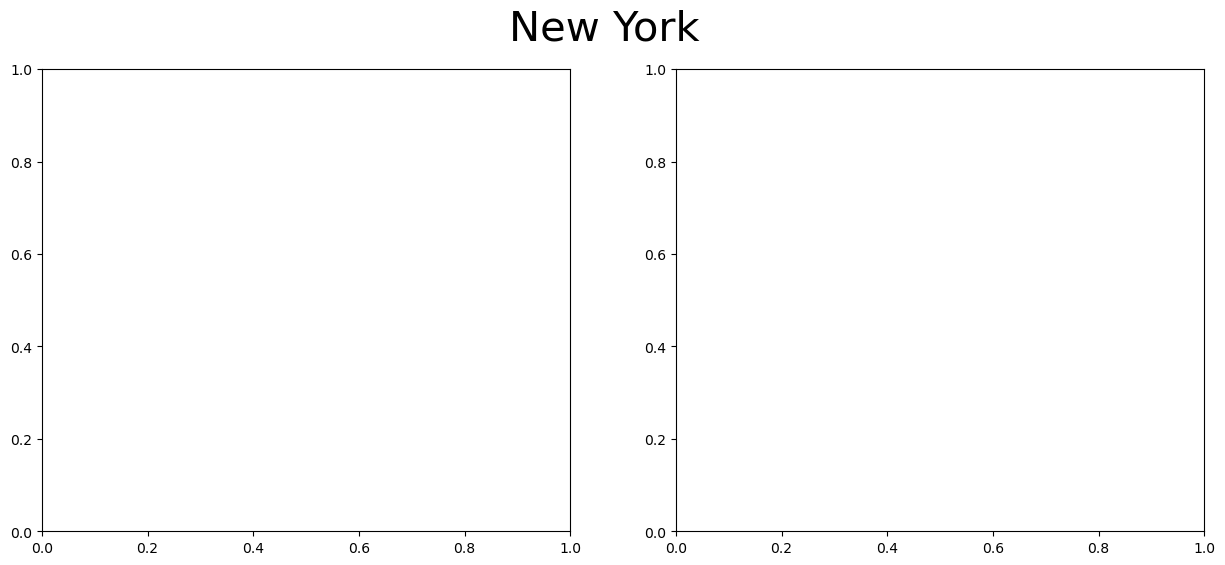

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharex=True)

st = fig.suptitle(country_to_string[country], fontsize=30)

avg_originals, avg_deeps, avg_originals_p, avg_deeps_p, avg_dg_sums = [], [], [], [], []
std_originals, std_deeps, std_originals_p, std_deeps_p, std_dg_sums = [], [], [], [], []

for decile in df.decile_n_oas.unique():
    df_temp = df[df.decile_n_oas == decile]

    avg_deep = df_temp.deep.mean()
    avg_original_p = df_temp.original_p.mean()
    avg_deep_p = df_temp.deep_p.mean()
    avg_original = df_temp.original.mean()

    avg_deeps.append(avg_deep)
    avg_originals_p.append(avg_original_p)
    avg_deeps_p.append(avg_deep_p)
    avg_originals.append(avg_original)

    std_deep = df_temp.deep.std()
    std_original_p = df_temp.original_p.std()
    std_deep_p = df_temp.deep_p.std()
    std_original = df_temp.original.std()

    std_deeps.append(std_deep)
    std_originals_p.append(std_original_p)
    std_deeps_p.append(std_deep_p)
    std_originals.append(std_original)

    relative_improve_original_p_deep = []
    relative_improve_original_p_deep_p = []
    relative_improve_original_p_original = []

for a, b in zip(avg_originals_p, avg_deeps):
    relative_improve_original_p_deep.append(((b - a) / a)*100)

for a, b in zip(avg_originals_p, avg_deeps_p):
    relative_improve_original_p_deep_p.append(((b - a) / a)*100)

for a, b in zip(avg_originals_p, avg_originals):
    relative_improve_original_p_original.append(((b - a) / a)*100)

# decile plots
ax = axes[0]

ax.errorbar(range(10), avg_deeps, yerr=std_deeps, marker='o',
          color=main_color, label='DG', linewidth=3, markersize=10)

# ax.errorbar(range(10), avg_deeps_p, yerr=std_deeps_p, marker='v',
#           color='lightgrey', label='NG', linewidth=2, markersize=10)  

# ax.errorbar(range(10), avg_originals_p, yerr=std_originals_p,
#           color='black', label='G', linestyle='--', linewidth=3)  


# ax.errorbar(range(10), avg_originals, yerr=std_originals, marker='s',
#           color='darkgrey', linewidth=2, 
#           label='MFG', markersize=8)

ax.set_ylabel('Average CPC', fontsize=25)
ax.set_xlabel('Decile population', fontsize=25)
ax.set_xticks(range(10))
ax.set_xticklabels(range(1, 11))
ax.set_ylim(0,1)
ax.tick_params(labelsize=20)
ax.grid(alpha=0.2)
ax.set_title(country_to_subid[country][0], fontsize=30)
ax.legend(fontsize=20, loc=1)

# relative improvement plot

ax = axes[1]

ax.plot(range(len(relative_improve_original_p_deep)), relative_improve_original_p_deep, color=main_color, linewidth=3, 
      marker='o', markersize=10)

ax.plot(range(len(relative_improve_original_p_deep_p)), relative_improve_original_p_deep_p, color='lightgrey', linewidth=2, 
      marker='v', markersize=8)

ax.plot(range(len(relative_improve_original_p_original)), relative_improve_original_p_original, color='darkgrey', linewidth=2, 
      marker='s', markersize=10)

ax.set_ylabel('Relative improvement (%)', fontsize=25)
ax.set_xlabel('Decile population', fontsize=25)
ax.set_ylim(0,max(relative_improve_original_p_deep)+max(relative_improve_original_p_deep)*0.1)
ax.tick_params(labelsize=20)
ax.set_title(country_to_subid[country][1], fontsize=30)
ax.grid(alpha=0.2)



plt.subplots_adjust(wspace=0.3)
#fig.suptitle(country2long_name[country], fontsize=20)
plt.tight_layout()
plt.savefig('../plots/average_cpc_'+country+'.pdf')

/var/folders/0r/42s0y7w165x_jyn8v8934q0h0000gn/T/ipykernel_4117/4167752347.py:86: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, max(relative_improve_original_p_deep) + max(relative_improve_original_p_deep) * 0.1)


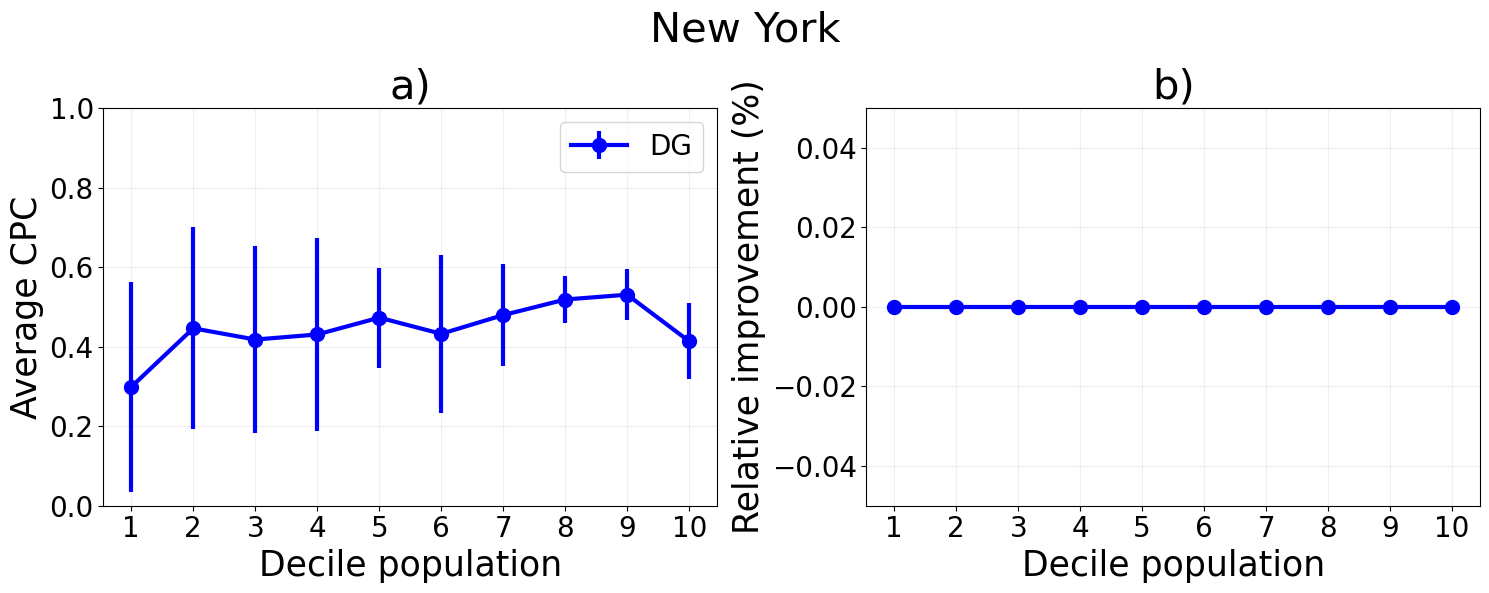

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import json

country = 'new_york'
main_color = 'red'
models = ['DG', 'G', 'MFG', 'NG']
rounds = ['0']

# Load the data
filename = 'tile2cpc_DG_new_york.csv'
df = pd.read_csv('deepgravity/results/' + filename)
df.set_index('tile', inplace=True)
df.fillna(0, inplace=True)
df.rename(columns={'cpc': '0_DG'}, inplace=True)

# Load the JSON file
json_file_path = 'deepgravity/data/' + country + '/processed/tileid2oa2handmade_features.json'
with open(json_file_path, 'r') as f:
    tileid2oa2features2vals = json.load(f)

# Preprocess the DataFrame
df.reset_index(inplace=True)
df = df[df['tile'] != 0]

# Calculate the number of areas
areas = list(df['tile'].unique())
tile_sizes = [len(tileid2oa2features2vals[str(area)].keys()) for area in areas]
df['n_oas'] = tile_sizes

# Define deciles
df['rank_oa'] = df['n_oas'].rank(method='first')
deciles_n_oas = pd.qcut(df['rank_oa'], q=10, labels=False, duplicates='drop')
df['decile_n_oas'] = deciles_n_oas

# Calculate mean values for the DG model
df['DG'] = df[[f'{x}_DG' for x in rounds]].mean(axis=1)
df.rename(columns={'DG': 'deep'}, inplace=True)
df = df.sort_values(by='decile_n_oas')

# Define country-to-string and country-to-subid mappings
country_to_string = {'new_york': 'New York'}
country_to_subid = {'new_york': ['a)', 'b)']}

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharex=True)
st = fig.suptitle(country_to_string[country], fontsize=30)

avg_deeps, std_deeps = [], []

for decile in df['decile_n_oas'].unique():
    df_temp = df[df['decile_n_oas'] == decile]
    avg_deep = df_temp['deep'].mean()
    avg_deeps.append(avg_deep)
    std_deep = df_temp['deep'].std()
    std_deeps.append(std_deep)

relative_improve_original_p_deep = []

for a, b in zip(avg_deeps, avg_deeps):
    relative_improve_original_p_deep.append(((b - a) / a) * 100)

# Decile plots
ax = axes[0]
ax.errorbar(range(10), avg_deeps, yerr=std_deeps, marker='o',
            color='blue', label='DG', linewidth=3, markersize=10)
ax.set_ylabel('Average CPC', fontsize=25)
ax.set_xlabel('Decile population', fontsize=25)
ax.set_xticks(range(10))
ax.set_xticklabels(range(1, 11))
ax.set_ylim(0, 1)
ax.tick_params(labelsize=20)
ax.grid(alpha=0.2)
ax.set_title(country_to_subid[country][0], fontsize=30)
ax.legend(fontsize=20, loc=1)

# Relative improvement plot
ax = axes[1]
ax.plot(range(len(relative_improve_original_p_deep)), relative_improve_original_p_deep, color='blue', linewidth=3, 
        marker='o', markersize=10)
ax.set_ylabel('Relative improvement (%)', fontsize=25)
ax.set_xlabel('Decile population', fontsize=25)
ax.set_ylim(0, max(relative_improve_original_p_deep) + max(relative_improve_original_p_deep) * 0.1)
ax.tick_params(labelsize=20)
ax.set_title(country_to_subid[country][1], fontsize=30)
ax.grid(alpha=0.2)

plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.savefig('plots/average_cpc_' + country + '.pdf')
